In [1]:
import os
import sys
sys.path.append(os.path.abspath('../datasets'))
sys.path.append(os.path.abspath('../trained_models'))
import pickle
import json

import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

from tensorflow.keras import Input, Model
from tensorflow.keras.applications.inception_v3 import preprocess_input

import matplotlib.pyplot as plt
np.random.seed(45)

In [2]:
# saved models
MEME_GEN_MODEL = "../weights/char_model_memefly60.h5"
TOKENIZER = "../weights/memefly02_tokenizer.pkl"
IMG_FEATURE_EXTRACTOR = "../weights/inceptionv3_embeddings.h5"
# Known in-sample images and out of sample test image
IN_SAMPLE_IMG = "../datasets/images/y-u-no.jpg"
OUT_OF_SAMPLE_IMG = "../datasets/Roll-Safe-Think-About-It.jpg"

In [3]:
def extract_features(model: tf.keras.models, img_file: str) -> np.ndarray:
    """
    Extracts image feature vectors from an image file using a pretrained/saved
    InceptionV3 model without classification layers.
    
    inputs:
    ========
    model: pretrained InceptionV3 model without classification layers.
    img_file: path/filename of the image file to be loaded.
    
    OUTPUTS:
    ========
    feature: image embeddings, shape (2048,0)
    
    """

    image = load_img(img_file, target_size=(299, 299))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    feature = model.predict(image, verbose=0)

    return feature

In [4]:
def idx2word(idx: int, tokenizer: tf.keras.preprocessing) -> str:
    """
    Translates from an integer to a word using pretrained tf.keras tokenizer

    inputs:
    ========
    idx: integer id of a word
    tokenizer: pretrained tf.keras tokenizer

    outputs:
    ========
    word: mapped word, string
    """
    for word, index in tokenizer.word_index.items():
        if index == idx:
            return word
    return None


def generate_text(model: tf.keras.models, tokenizer: tf.keras.preprocessing, img_emb: np.ndarray, max_length: int) -> str:
    """
    This function generates text using trained image captioning model. To generate
    text, we have to seed the sentence with a 'startseq' token. We will then use the
    model to predict the next word in the sequence, until the next word is either
    None or 'endseq'. We choose to use 'startseq' and 'endseq' to mark the beginning
    and the end of the sentence as start/end are common words, and <START> and <END>
    will get scrubbed/cleaned by Keras tokenizers.

    Input:
    ========
    model: pretrained and loaded keras model
    tokenizer: pretrained tokenizer that's responsible to convert from either word to
    integer or integer to word
    img_emb: image feature vector extracted using pretrained InceptionV3, expected 
    shape (2048,)
    max_length: maximum length of the generated meme text

    Output:
    ========
    sentence: sentences, python string.
    """
    # seed the start of the sentence
    sentence = '{'

    for i in range(max_length):
        # encode input sequence to integer
        sequence = tokenizer.texts_to_sequences([sentence])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)#, padding='post')

        next_word = model.predict([img_emb, sequence], verbose=0)
        next_word = np.argmax(next_word)
        word =idx2word(next_word, tokenizer)

        # stop generating text if we cannot map the word or reach the end of the sentence
        if word is None:
            break
        #sentence += ' ' + word
        sentence += word
        if word == '}':
            break
            
    # remove startseq and endseq
    #sentence = ''.join(w for w in sentence if w not in ['{', '}'])

    return sentence

In [5]:
%%time 
# load the tokenizer model, image feature extractor model, and image captioning model
tokenizer = pickle.load(open(TOKENIZER, 'rb'))
img_vec_model = tf.keras.models.load_model(IMG_FEATURE_EXTRACTOR, compile=False) # have to add compile=False to squelch warnings #InceptionV3(include_top=False, pooling='avg', weights='imagenet')
model = tf.keras.models.load_model(MEME_GEN_MODEL)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
CPU times: user 18.9 s, sys: 324 ms, total: 19.2 s
Wall time: 18.9 s


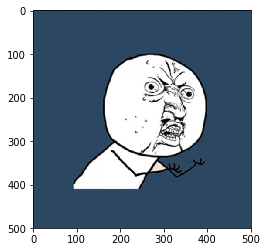

[[0.02642976 0.14982153 0.15719073 ... 0.19089581 0.00570035 0.08787567]]
{i don't always urine your at the corporate with a smelter}
CPU times: user 22.8 s, sys: 5.61 s, total: 28.5 s
Wall time: 11.6 s


In [6]:
%%time
# pre-define the max sequence length (from training)
# max length calculatted in 02_meme_gen_model_0.0.1 notebook
max_length = 136
# display the image
plt.imshow(load_img(IN_SAMPLE_IMG))
plt.show()

# load and prepare the image
image_embeddings1 = extract_features(img_vec_model, IN_SAMPLE_IMG)
print(image_embeddings1)

# generate and preint out the description
description = generate_text(model, tokenizer, image_embeddings1, max_length)
print(description)

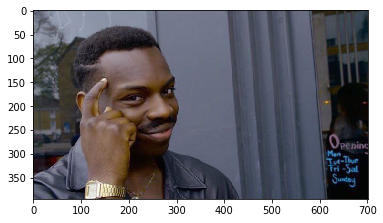

[[0.77027935 0.13557787 0.5603315  ... 0.8796478  0.8306446  0.24693567]]
{i don't always urine you're a cat}
CPU times: user 10.7 s, sys: 3.3 s, total: 14 s
Wall time: 3.93 s


In [7]:
%%time
# pre-define the max sequence length (from training)
max_length = 136
plt.imshow(load_img(OUT_OF_SAMPLE_IMG))
plt.show()
# load and prepare the photograph
image_embeddings2 = extract_features(img_vec_model, OUT_OF_SAMPLE_IMG)
print(image_embeddings2)
# generate description
description = generate_text(model, tokenizer, image_embeddings2, max_length)
print(description)

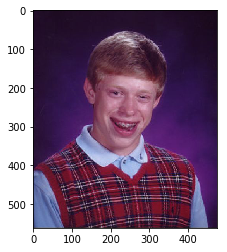

[[0.7624111  0.11517906 0.15682481 ... 0.32519513 0.35486272 0.09429938]]
{this is is the best with you eat this is it's boieb's by a bun'na}


In [8]:
IN_SAMPLE_IMG2 = "../datasets/images/bad-luck-brian.jpg"
plt.imshow(load_img(IN_SAMPLE_IMG2 ))
plt.show()
# load and prepare the photograph
image_embeddings3 = extract_features(img_vec_model, IN_SAMPLE_IMG2)
print(image_embeddings3)
# generate description
description = generate_text(model, tokenizer, image_embeddings3, max_length)
print(description)

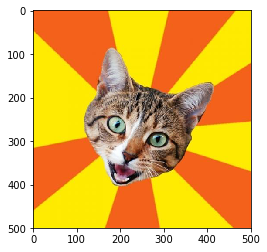

[[0.12613802 0.28409952 0.09872783 ... 0.48601678 1.6461786  0.13294345]]
{i don't always urine you're a cat}


In [9]:
IN_SAMPLE_IMG3 = "../datasets/images/bad-advice-cat.jpg"
plt.imshow(load_img(IN_SAMPLE_IMG3))
plt.show()
# load and prepare the photograph
image_embeddings4 = extract_features(img_vec_model, IN_SAMPLE_IMG3)
print(image_embeddings4)
# generate description
description = generate_text(model, tokenizer, image_embeddings4, max_length)
print(description)

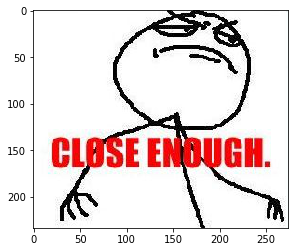

[[0.56024367 0.15091239 0.07864296 ... 0.00493287 0.21443543 0.08812056]]
{i don't always urine your at the corporate with a smelter}


In [10]:
IN_SAMPLE_IMG4 = "../datasets/images/close-enough.jpg"
plt.imshow(load_img(IN_SAMPLE_IMG4))
plt.show()
# load and prepare the photograph
image_embeddings5 = extract_features(img_vec_model, IN_SAMPLE_IMG4)
print(image_embeddings5)
# generate description
description = generate_text(model, tokenizer, image_embeddings5, max_length)
print(description)

In [11]:
from numpy import dot
from numpy.linalg import norm

def cos_sim(a, b):
    print(a.T.dot(b)/(norm(a)*norm(b)))
    return None

In [12]:
from sklearn.metrics.pairwise import cosine_similarity as cos_sim

#cosine_similarity([[1, 0, -1]], [[-1,-1, 0]])


In [13]:
print(cos_sim(image_embeddings1, image_embeddings1))
print(cos_sim(image_embeddings1, image_embeddings2))
print(cos_sim(image_embeddings1, image_embeddings3))
print(cos_sim(image_embeddings1, image_embeddings4))
print(cos_sim(image_embeddings1, image_embeddings5))
print(cos_sim(image_embeddings2, image_embeddings1))
print(cos_sim(image_embeddings2, image_embeddings2))
print(cos_sim(image_embeddings2, image_embeddings3))
print(cos_sim(image_embeddings2, image_embeddings4))
print(cos_sim(image_embeddings2, image_embeddings5))
print(cos_sim(image_embeddings3, image_embeddings1))
print(cos_sim(image_embeddings3, image_embeddings2))
print(cos_sim(image_embeddings3, image_embeddings3))
print(cos_sim(image_embeddings3, image_embeddings4))
print(cos_sim(image_embeddings3, image_embeddings5))
print(cos_sim(image_embeddings4, image_embeddings1))
print(cos_sim(image_embeddings4, image_embeddings2))
print(cos_sim(image_embeddings4, image_embeddings3))
print(cos_sim(image_embeddings4, image_embeddings4))
print(cos_sim(image_embeddings4, image_embeddings5))

[[1.]]
[[0.5560577]]
[[0.56439865]]
[[0.5324462]]
[[0.63745743]]
[[0.5560577]]
[[1.0000001]]
[[0.6235937]]
[[0.54184824]]
[[0.5508398]]
[[0.56439865]]
[[0.6235937]]
[[1.0000001]]
[[0.5016148]]
[[0.51888955]]
[[0.5324462]]
[[0.54184824]]
[[0.5016148]]
[[1.]]
[[0.52803683]]


In [19]:
import nltk

hypothesis = "i don't always urine you're a cat".split(' ')# ['It', 'is', 'a', 'cat', 'at', 'room']
reference = "you should upgrade to windows 10".split(' ')# ['It', 'is', 'a', 'cat', 'inside', 'the', 'room']
#there may be several references
BLEUscore = nltk.translate.bleu_score.sentence_bleu([reference], hypothesis)
print(BLEUscore)

0


In [14]:
# Test image feature extraction time
%timeit image_embeddings = extract_features(img_vec_model, OUT_OF_SAMPLE_IMG)

294 ms ± 13.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [15]:
# Test description generation time.
%timeit description = generate_text(model, tokenizer, image_embeddings, max_length)

NameError: name 'image_embeddings' is not defined